# Домашнее задание

[Ссылка](https://colab.research.google.com/drive/1t8Mqi3Q5mHJaTbNMa-UXz4aITa47mpe1?usp=sharing#scrollTo=GkgBFGALGsRu)

## Настройки

In [68]:
DOWNLOAD_DATASET = False
GENERATE_DATASET = False

In [69]:
%reload_ext autoreload
%autoreload 2

%reload_ext rich

## Импорты

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium

from maporgs.src.config import path, constants
from maporgs.src.config.rich import console
from maporgs.src.data.utils import (
    download_dataset,
    generate_dataset,
    load_dataset,
    save_dataset,
)
from maporgs.src.process import coords

console.print("Импортировано!", style="info")

Импортировано!

## Скачивание и генерация данных

In [71]:
if DOWNLOAD_DATASET:
    download_dataset(constants.DATASET_ID, path.DEFAULT_DATASET_PATH)
    console.print("Данные скачаны", style="info")

In [72]:
if GENERATE_DATASET:
    df = load_dataset(path.DEFAULT_DATASET_PATH)
    indf = generate_dataset(df, constants.OPTION_NUMBER, constants.STEP)
    save_dataset(indf, path.DEFAULT_INDIVIDUAL_DATASET_PATH)
    console.print("Данные сгенерированы и сохранены", style="info")

Данные сгенерированы и сохранены

## Загрузка данных

In [73]:
df = load_dataset(path.DEFAULT_DATASET_PATH)
df.head(2)

,address,name_ru,rubrics,rating,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,['Жилой комплекс'],3,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,"['Магазин продуктов', 'Продукты глубокой замор...",5,"Замечательная сеть магазинов в общем, хороший ..."


In [74]:
indf = load_dataset(path.DEFAULT_INDIVIDUAL_DATASET_PATH)
len(indf)

25000

## Определение координат

In [75]:
def get_coordinates(address):
    location = coords.coords_by_address(address)
    if not location:
        return None, None, None, None
    return (
        get_subject(location),
        get_city(location),
        location.longitude,
        location.latitude,
    )


def get_subject(location):
    return location.raw.get("address").get("region")


def get_city(location):
    return location.raw.get("address").get("city")


indf = indf.head(100)


indf.loc[:, ["coords_subject", "coords_city", "coords_lon", "coords_lat"]] = (
    indf["address"].apply(get_coordinates).tolist()
)


indf.head(5)

,address,name_ru,rubrics,rating,text,coords_subject,coords_city,coords_lon,coords_lat
0,"Воронежская область, Богучарский район, М-4 До...",У тещи,['Кафе'],4,Глубинка страны во всех своих проявлениях. Асс...,None,None,NaN,NaN
1,"Ямало-Ненецкий автономный округ, Новый Уренгой...",Dream Hostel,['Хостел'],5,"Отлично!\nОсобенно, ""трешка""-трёхместный номер...",Уральский федеральный округ,Новый Уренгой,76.628852,66.077064
2,"Екатеринбург, ул. Хрустальногорская",Nova park,['Жилой комплекс'],1,"Когда выбирали квартиру, Атом был в приоритете...",Уральский федеральный округ,Екатеринбург,60.499358,56.795107
3,"Москва, Большая Пионерская улица, 5с1",Хеликс,"['Диагностический центр', 'Медицинская лаборат...",5,Прекрасный центр с \n высококвалифицированными...,None,None,NaN,NaN
4,"Москва, Шлюзовая набережная, 2А",Libro Beauty,"['Ногтевая студия', 'Визажисты, стилисты', 'Са...",5,Профессиональные мастера — все как на подбор. ...,Центральный федеральный округ,Москва,37.643344,55.730945


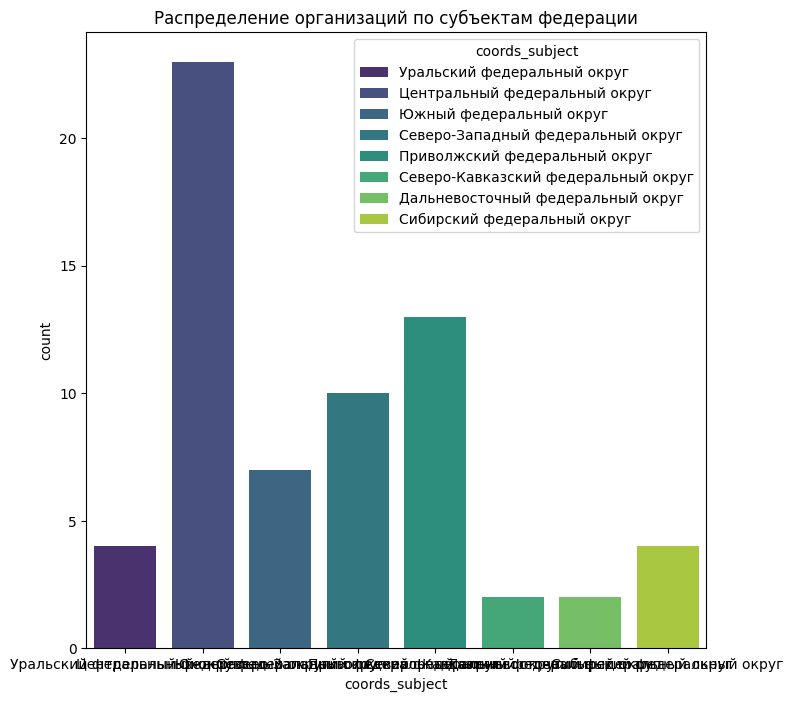

In [76]:
plt.figure(figsize=(8, 8))
sns.countplot(x="coords_subject", data=indf, palette="viridis", hue="coords_subject")
plt.title("Распределение организаций по субъектам федерации")
plt.show()

In [77]:
m = folium.Map(
    location=[indf["coords_lat"].mean(), indf["coords_lon"].mean()], zoom_start=5
)

grouped_data = indf.groupby("coords_city")

for city, group in grouped_data:
    size = len(group)
    ratio = (
        len(group[group["coords_lon"].isnull() | group["coords_lat"].isnull()]) / size
    )
    avg_rating = round(group["rating"].mean(), 1)

    marker = folium.CircleMarker(
        location=[group["coords_lat"].mean(), group["coords_lon"].mean()],
        radius=size,
        color=f"#{int(255 * (1 - ratio)):02X}{int(255 * ratio):02X}00",
        fill=True,
        fill_color=f"#{int(255 * (1 - ratio)):02X}{int(255 * ratio):02X}00",
        fill_opacity=0.6,
        popup=f"{city}\nКол-во организаций: {size}\nСредний рейтинг: {avg_rating}",
    )
    folium.Popup(html=f"{city}\nКол-во организаций: {size}\nСредний рейтинг: {avg_rating}", max_width=200).add_to(marker)
    marker.add_to(m)
m.save(path.DEFAULT_MAP_PATH)